## Calibration of Au SAED data 
Adapted from Tina Bergh


In [2]:
# PACKAGES
import numpy as np
import hyperspy.api as hs # v1.7.1
import matplotlib.pyplot as plt 
import copy
import skimage as ski
import pyxem as pxm  # v0.14.2 dependent on Pint v0.19.1

from pyxem.generators.calibration_generator import CalibrationGenerator
from scipy.signal import argrelextrema

from hyperspy.misc.utils import stack as stack_method
from numpy import log10
import matplotlib.colors as colors

from scipy.spatial import distance_matrix

In [9]:
#############
# Measurements on SAED patterns:
########################

file = 'AuX_80kV_200cm'
folder = 'C:/Users/Windows User/Documents/NTNU/Prosjekt og master/master/Data/DataFebruar/240215_AuX_80kV/' #C:\Users\Windows User\Documents\NTNU\Prosjekt og master\master\Data\DataFebruar\240215_AuX_80kV

# Intial loading of .mib file
file_ending = '.mib'
saed = pxm.load_mib(folder + file + file_ending)
saed.compute()
saed = pxm.signals.ElectronDiffraction2D(saed).inav[0]
saed.save(folder+file+'_s.hdf5')


This mib file appears to be TEM data. The stack is returned with no reshaping.
[########################################] | 100% Completed | 175.14 ms


NameError: name 's_max' is not defined

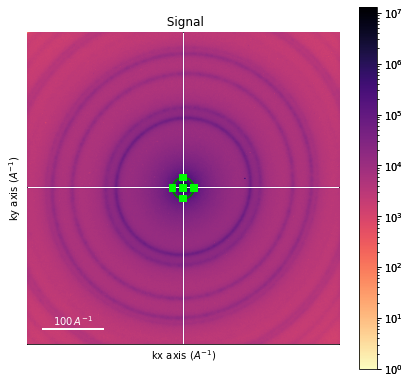

In [10]:
#Set scale
scale = 1
saed.set_diffraction_calibration(scale)
saed.plot(cmap='magma_r', norm='log')
roi = hs.roi.CircleROI(cx=0, cy=0, r=18, r_inner=0)
roi.add_widget(saed)

#s_max??????
cx = int((roi.cx - s_max.axes_manager[0].offset) / scale)
cy = int((roi.cy - s_max.axes_manager[1].offset) / scale)
r = int(roi.r / scale)

s_com = saed.center_of_mass(mask=(cx, cy, r))
saed.shift_diffraction(shift_x=s_com.inav[0] - cx, shift_y=s_com.inav[1] - cy, inplace=True)
saed.plot(cmap='magma_r', norm='log')

saed.save(folder+file+'_center.hdf5')


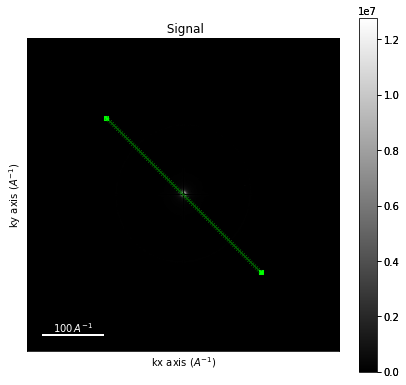

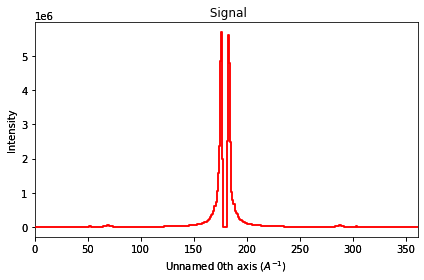

In [11]:

cal = CalibrationGenerator(diffraction_pattern=saed)

# Plot saed diffraction pattern
saed.plot()
line = hs.roi.Line2DROI(x1=-128, y1=-128, x2=128, y2=128, linewidth=5)
line.add_widget(saed)

# Obtain line trace (here set to go through center of beam)
trace = line(saed)
trace = trace.as_signal1D(0)
trace.plot()

20 mask_length


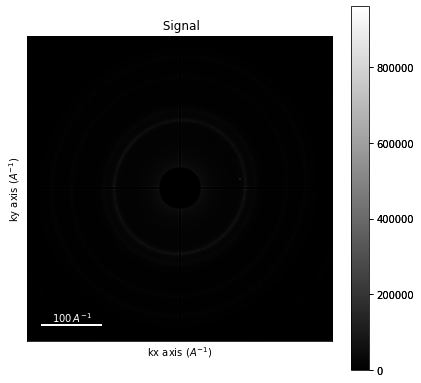

In [12]:

# Find half length of line trace, which lies on the diagonal
db = (np.sqrt(2) * 128) - (5 * np.sqrt(2))

# for local minima
minis = argrelextrema(trace.data, np.less, order=4)[0]
minis = minis[np.argsort(np.absolute([minis - db]))[0]][:2]
mask_length = abs(int((minis[0] - minis[1]) / 2))
print(mask_length, 'mask_length')

radius = 35
ssum_m = saed.copy()
dbm = ssum_m.get_direct_beam_mask(radius=radius)
ssum_m.data = ssum_m.data * ~dbm.data
ssum_m.plot()

[[0.98725 0.01969 0.     ]
 [0.01969 0.96961 0.     ]
 [0.      0.      1.     ]]
[   257.43856  35539.25768      5.04402   1924.28828      0.91558
 690546.62312]
[########################################] | 100% Completed | 123.30 ms
[########################################] | 100% Completed | 110.57 ms
[########################################] | 100% Completed | 114.60 ms
[########################################] | 100% Completed | 122.57 ms
scale=0.00457


c:\Users\Windows User\anaconda3\lib\site-packages\diffsims\utils\ring_pattern_utils.py:102: RuntimeWarning: divide by zero encountered in power
  v.append(direct_beam_amplitude * Ri ** -2)  # np.exp((-1*(Ri)*(Ri))/d0)


[########################################] | 100% Completed | 115.29 ms
[########################################] | 100% Completed | 107.93 ms
[########################################] | 100% Completed | 111.18 ms


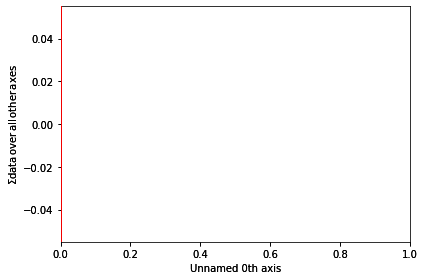

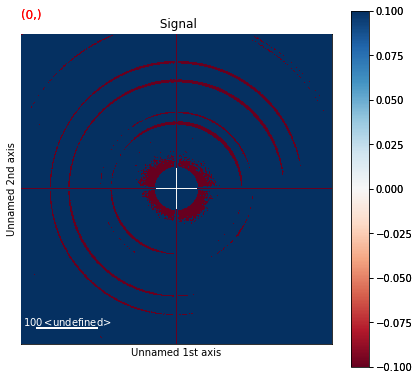

In [13]:

# plt.savefig(folder2+folder3+'ssum_masked_r28.png')
## NB had to use much higher spread than usual. Low spread, as usual (5-10) gave very wrong and skewed pattern....
spread = 2 #org 2
distortion = cal.get_elliptical_distortion(mask_radius=radius,
                                           scale=100, amplitude=1000,
                                           asymmetry=1.0, spread=spread)
np.set_printoptions(precision=5, suppress=True)
print(cal.affine_matrix)
print(cal.ring_params)

# mask_length = 30
linewidth = 5
scale = cal.get_diffraction_calibration(mask_length=mask_length, linewidth=linewidth)
print('scale=' + '{:.5f}'.format(scale))

residuals = cal.get_distortion_residuals(mask_radius=radius, spread=spread)
residuals.plot(cmap='RdBu', vmax=0.04)


[########################################] | 100% Completed | 114.41 ms
[########################################] | 100% Completed | 108.55 ms
[########################################] | 100% Completed | 115.53 ms
[########################################] | 100% Completed | 225.03 ms
[0.00933 0.00934 0.00931 0.00929] 1.8861038854866676e-05 0.009320257285219166
0.009320257285219166


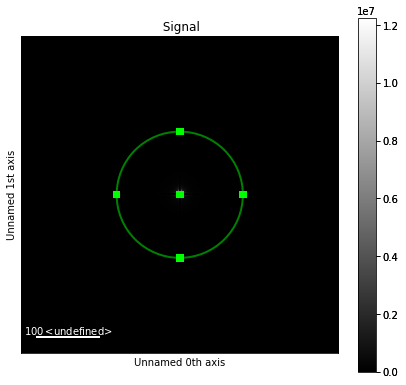

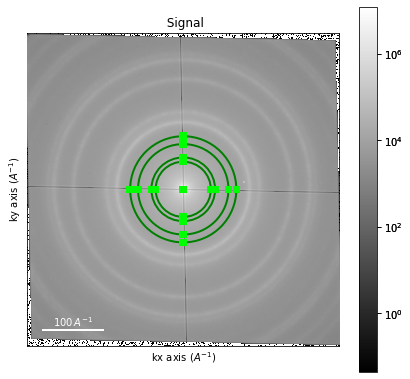

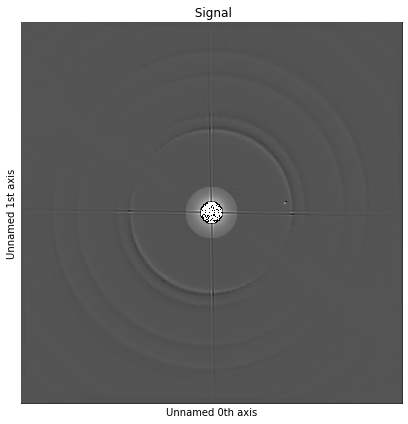

In [14]:

# plt.savefig(folder2+folder3+'ssum_r28_spread5_residuals.png')

cal.plot_corrected_diffraction_pattern()

np.savetxt(folder + file + '_dist.txt', distortion)

ids = [0.424730458, 0.490436488, 0.693581933, 0.813296908, 0.849460916, 0.980872977]

size = ssum_m.data.shape[0]
dpegs = stack_method([saed, saed, saed, saed])
dpegs = pxm.signals.ElectronDiffraction2D(dpegs.data.reshape((2, 2, size, size)))
# dpegs.set_diffraction_calibration(scale)
dpegs = dpegs.apply_affine_transformation(
    cal.affine_matrix, preserve_range=True, inplace=False)
dpegm = dpegs.inav[0, 0]
dpegm.set_diffraction_calibration(1)
dpegm.plot(norm='log')
roi111 = hs.roi.CircleROI(cx=0, cy=0, r=45.5)
roi111.add_widget(dpegm)
roi002 = hs.roi.CircleROI(cx=0, cy=0, r=52.5)
roi002.add_widget(dpegm)
roi022 = hs.roi.CircleROI(cx=0, cy=0, r=74.5)
roi022.add_widget(dpegm)
roi113 = hs.roi.CircleROI(cx=0, cy=0, r=87.5)
roi113.add_widget(dpegm)

scales = np.array([ids[0] / roi111.r, ids[1] / roi002.r, ids[2] / roi022.r, ids[3] / roi113.r])
print(scales, np.std(scales), np.mean(scales))
calibration = np.mean(scales)
print(calibration)

np.savetxt(folder + file + '_calibration.txt', [calibration])

plt.savefig(folder+file + '_cal_rings.png')

diff = dpegs.inav[0, 0].data - ssum_m.data
if np.any(diff < 0.0):
    diff = diff + abs(np.min(diff.data))
# diff -= np.min(diff[diff>0.0])
diff = pxm.signals.ElectronDiffraction2D(diff)
diff_m = diff.copy()
dbm_ = diff_m.get_direct_beam_mask(radius=15)
diff_m.data = diff_m.data * ~dbm_.data
diff_m.plot(norm='log', scalebar=False, colorbar=False, axes_ticks=False)
plt.savefig(folder + file + '_diff.png')
diff_img = diff_m.copy()
diff_img.data = diff_img.data / diff_img.data.max()
diff_img.data = ski.img_as_uint(diff_img.data)
diff_img.save(folder + file + '_diff.tif')
shift = diff_m.data[diff_m.data > 0].min()
diff_log = diff_m.copy()
diff_log.data = log10(diff_m.data + shift) - log10(shift)
diff_log.data = diff_log.data / diff_log.data.max()
diff_log.data = ski.img_as_uint(diff_log.data)
diff_log.save(folder + file + '_diff_log.tif') 